In [1]:
import argparse
import os
import shutil
import sys
import pickle
import h5py
import torch
import numpy as np
import json
import lib.init as init
from lib.runner import runner
import matplotlib.pyplot as plt

In [6]:
# save stdout and stderr location
stdout = sys.stdout
stderr = sys.stderr

config_file = 'configs/re30k_6ktrain.json'
with open(config_file, "r") as f:
    config = json.load(f)
        
config['overwrite'] = None
config['mode'] = 'eval'
device = ('cuda' if torch.cuda.is_available() else "cpu")
config['device'] = device
run = runner(config)

# reopen stdout and stderr
sys.stdout = stdout
sys.stderr = stderr

In [7]:
time_lag = run.config['params']['time_lag']

In [8]:
train_indices = run.train_indices

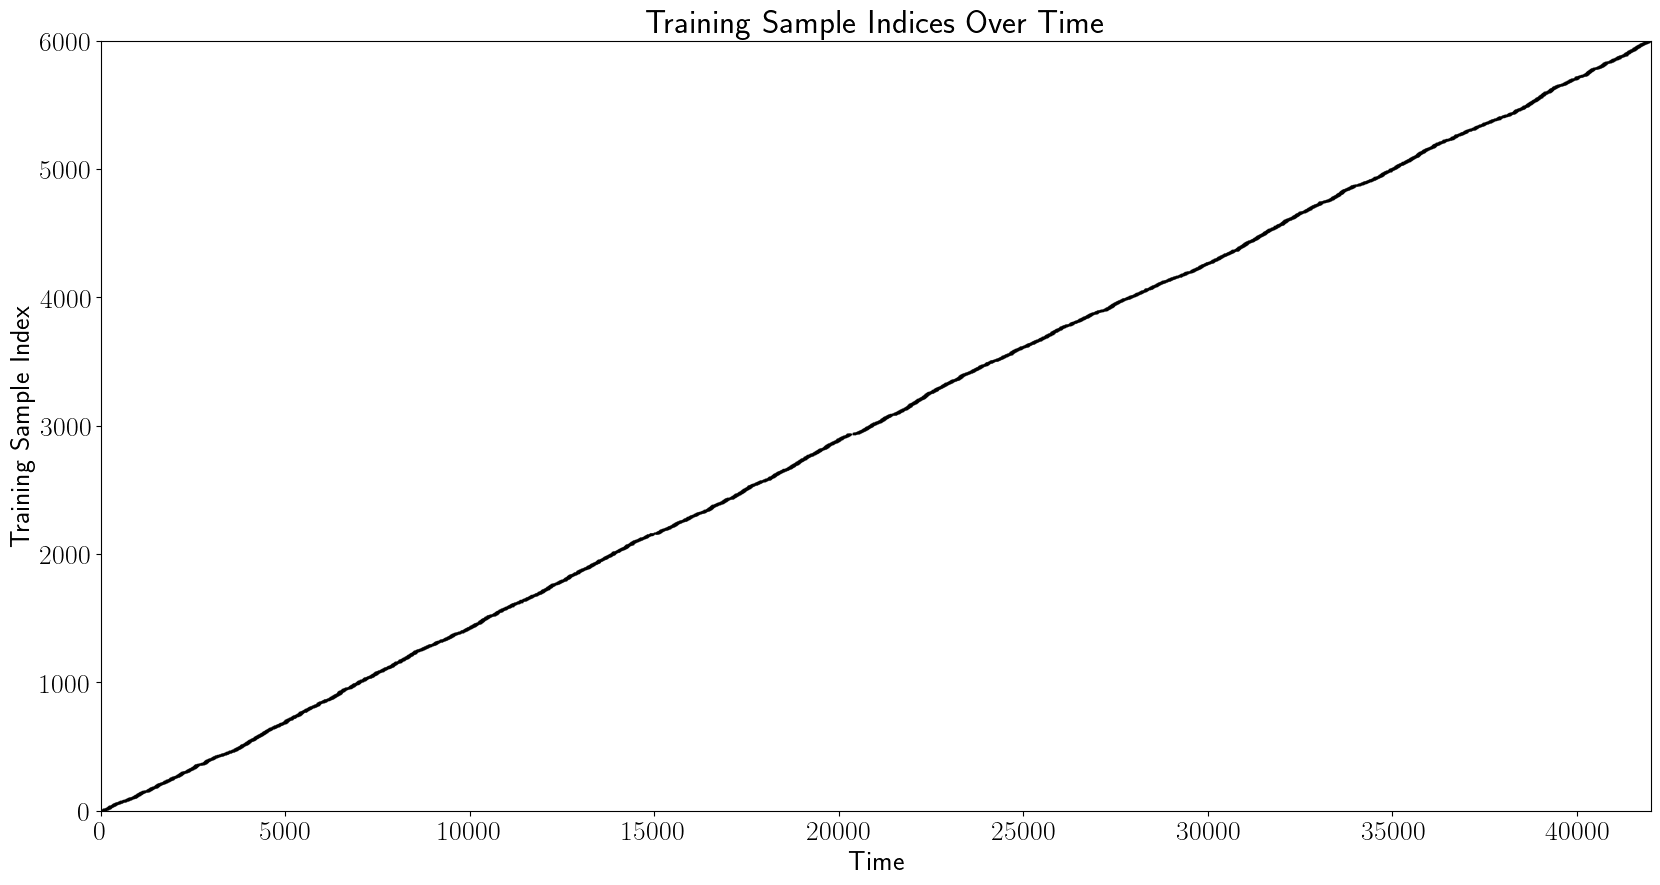

In [29]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['text.usetex'] = True

plt.figure(figsize=(20, 10))
for i in range(len(train_indices)):
    plt.plot(range(train_indices[i], train_indices[i] + time_lag + 5 + 1), np.ones(time_lag + 5 + 1) * i, color='black', linewidth=1)

plt.ylim([0, 6000])
plt.xlim([0, 42000])
plt.xlabel('Time')
plt.ylabel('Training Sample Index')
plt.title('Training Sample Indices Over Time')
plt.show()
